In [94]:
import os
from os.path import isfile, join
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set_theme()

In [95]:
OUTPUT_DIR = 'out-bak'
WINDOWS = 'windows'
LINUX = 'linux'

OUT_ASSETS_PATH = 'doc/assets/'
DPI = 300
CI = 99
reports = [f for f in os.listdir(OUTPUT_DIR) if isfile(join(OUTPUT_DIR, f)) and f[0] != '.']

In [96]:
HEADER = {'matrix': str, 'os': str, 'script': str, 'run': int,
          'size': int, 'nnz': int, 'error': float, 'time': float,
          'mem_peak': float, 'mem_avg': float}
data = []
for report in reports:
    with open(join(OUTPUT_DIR, report), 'r') as f:
        new_line = []
        metadata = report.split('.')[0].split('-')
        new_line += [metadata[1], metadata[0], metadata[2], metadata[3]]
        new_line += f.readline().split(';')
        data.append(new_line)
df_file = pd.DataFrame(data=data, columns=HEADER.keys())
df_file = df_file.sort_values(by=["matrix", "os", "script", "run"], ignore_index=True)
df_file = df_file.astype(HEADER)

df_file.head()

,matrix,os,script,run,size,nnz,error,time,mem_peak,mem_avg
0,G3_circuit,linux,matlab,1,2513740488484,7660826,3.575745e-12,8.532280,2.795897e+09,9.018203e+08
1,G3_circuit,linux,matlab,10,2513740488484,7660826,3.575745e-12,9.039869,2.794025e+09,1.035058e+09
2,G3_circuit,linux,matlab,2,2513740488484,7660826,3.575745e-12,8.519243,2.791514e+09,9.977597e+08
3,G3_circuit,linux,matlab,3,2513740488484,7660826,3.575745e-12,8.604503,2.797154e+09,1.002621e+09
4,G3_circuit,linux,matlab,4,2513740488484,7660826,3.575745e-12,8.767106,2.791551e+09,1.011790e+09


## Estrazione metadati matrici

In [97]:
df_metadata = df_file.query('run == 1 & script == "matlab" & os == "linux"')
df_metadata = df_metadata[["matrix", "size", "nnz"]]
df_metadata = df_metadata.reset_index(drop=True)
df_metadata


,matrix,size,nnz
0,G3_circuit,2513740488484,7660826
1,GT01R,63680400,430909
2,Hook_1498,2244072908529,59374451
3,TSC_OPF_1047,66259600,2012833
4,bundle_adj,263529249201,20207907
5,ifiss_mat,9275038249,3599932
6,nd24k,5184000000,28715634
7,ns3Da,416731396,1679599


## Pulizia del dataframe dei file

In [98]:
df = df_file
df = df.drop(columns=["size", "nnz"])
df.head(5)

,matrix,os,script,run,error,time,mem_peak,mem_avg
0,G3_circuit,linux,matlab,1,3.575745e-12,8.532280,2.795897e+09,9.018203e+08
1,G3_circuit,linux,matlab,10,3.575745e-12,9.039869,2.794025e+09,1.035058e+09
2,G3_circuit,linux,matlab,2,3.575745e-12,8.519243,2.791514e+09,9.977597e+08
3,G3_circuit,linux,matlab,3,3.575745e-12,8.604503,2.797154e+09,1.002621e+09
4,G3_circuit,linux,matlab,4,3.575745e-12,8.767106,2.791551e+09,1.011790e+09


## Plot risultati

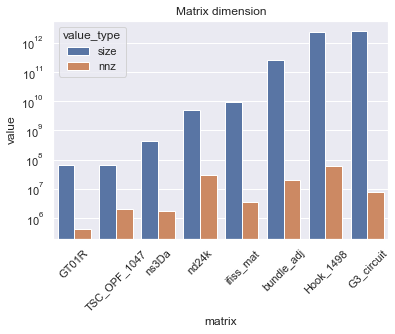

In [99]:
order_nnz = df_metadata.sort_values(by="nnz", ascending=True)["matrix"]

df_metadata_aux = pd.concat([df_metadata, df_metadata]).reset_index(drop=True)
df_metadata_aux["value_type"] = ["size"] * len(df_metadata) +  ["nnz"] * len(df_metadata)
df_metadata_aux["value"] = list(df_metadata["size"]) + list(df_metadata["nnz"])
df_metadata_aux = df_metadata_aux.drop(columns=["size", "nnz"])

# Matrix dimension
g = sns.barplot(data=df_metadata_aux, x="matrix", y="value", hue="value_type", log=True,
                order=df_metadata.sort_values(by="size", ascending=True,)['matrix']).set_title("Matrix dimension")
plt.xticks(rotation=45)

plt.savefig(f"{OUT_ASSETS_PATH + 'dimension1'}.jpg", bbox_inches='tight', dpi=DPI)

plt.show()

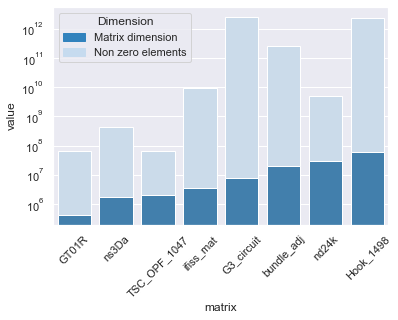

In [100]:
palette = sns.color_palette("tab20c")
light, dark = palette[0], palette[3]

# top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="matrix",  y="value", data=df_metadata_aux.query('value_type=="size"'), log=True,
                    color=dark, order=order_nnz)

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="matrix", y="value", data=df_metadata_aux.query('value_type=="nnz"'), log=True,
                    color=light, order=order_nnz)

# add legend
top_bar = mpatches.Patch(color=light, label='Matrix dimension')
bottom_bar = mpatches.Patch(color=dark, label='Non zero elements')
plt.legend(handles=[top_bar, bottom_bar], title="Dimension")
plt.xticks(rotation=45)
# show the graph
plt.savefig(f"{OUT_ASSETS_PATH + 'dimension2'}.jpg", bbox_inches='tight', dpi=DPI)
plt.show()

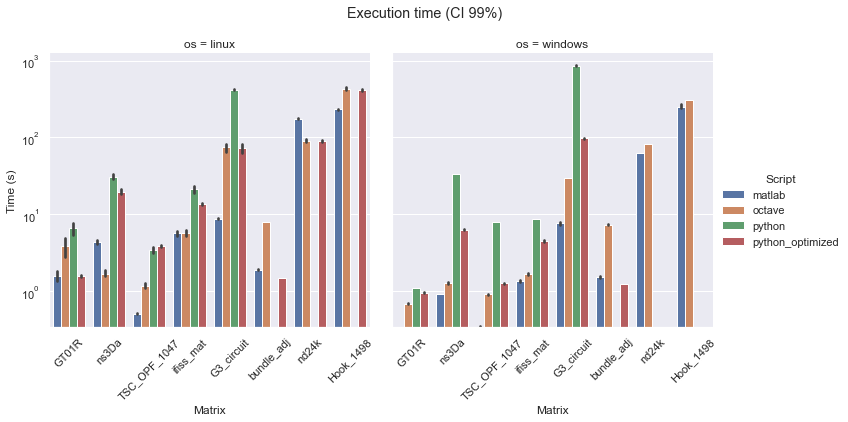

In [101]:
# Time
g = sns.catplot(x="matrix", y="time", hue="script", col="os", kind='bar', data=df, ci=CI, log=True,
                 order=order_nnz)
g.set_axis_labels('Matrix', "Time (s)")
g.legend.set_title("Script")
g.fig.subplots_adjust(top=0.85) # adjust the Figure in rp
g.fig.suptitle(f'Execution time (CI {CI}%)')

for ax in g.axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set(rotation=45)

plt.savefig(f"{OUT_ASSETS_PATH + 'execution'}.jpg", bbox_inches='tight', dpi=DPI)

plt.show()

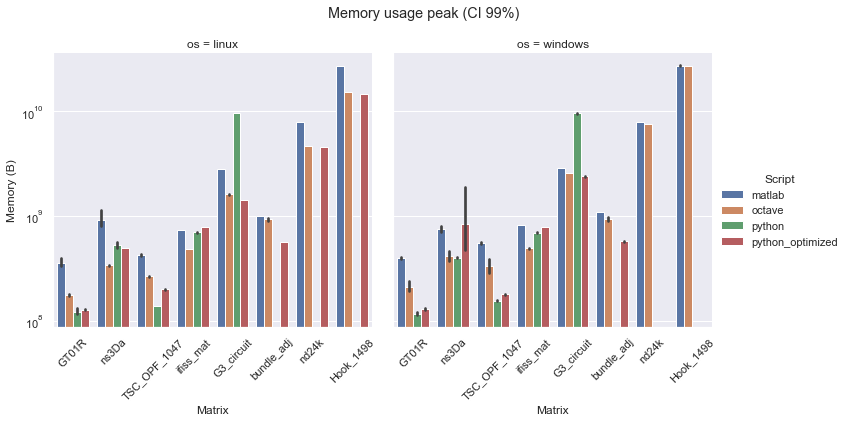

In [102]:
g = sns.catplot(x="matrix", y="mem_peak", hue="script", col="os", kind='bar', data=df, ci=CI, log=True,
                 order=order_nnz)
g.set_axis_labels('Matrix', "Memory (B)")
g.legend.set_title("Script")
g.fig.subplots_adjust(top=0.85) # adjust the Figure in rp
g.fig.suptitle(f'Memory usage peak (CI {CI}%)')

for ax in g.axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set(rotation=45)

plt.savefig(f"{OUT_ASSETS_PATH + 'memory'}.jpg", bbox_inches='tight', dpi=DPI)

plt.show()

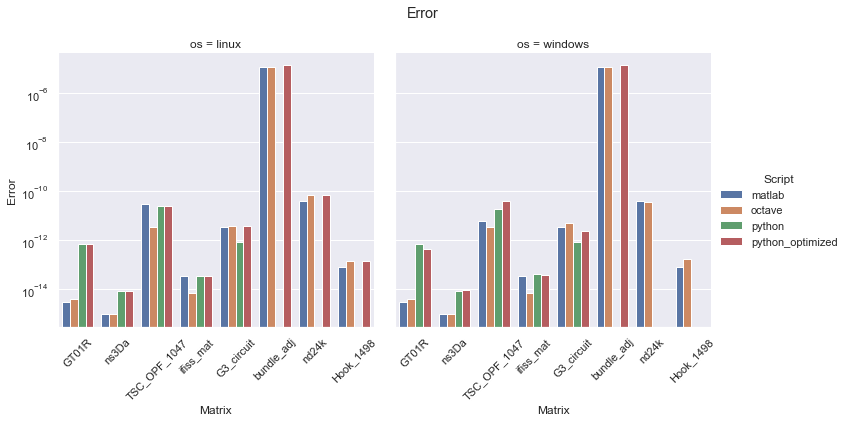

In [103]:
g = sns.catplot(x="matrix", y="error", hue="script", col="os", kind='bar', data=df, ci=CI, log=True,
                 order=order_nnz)
g.set_axis_labels('Matrix', "Error")
g.legend.set_title("Script")
g.fig.subplots_adjust(top=0.85) # adjust the Figure in rp
g.fig.suptitle(f'Error')

for ax in g.axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set(rotation=45)

plt.savefig(f"{OUT_ASSETS_PATH + 'error'}.jpg", bbox_inches='tight', dpi=DPI)

plt.show()

